In [10]:
import logging
from typing import Literal, Optional

from langchain.tools import Tool
from typing import Annotated
from langchain_core.tools import tool
from langgraph.prebuilt import InjectedState
# from langchain_community.chat_models import BaseChatModel
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langgraph.types import Command
from langchain_core.tools import tool
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode
from langchain import hub
from research_tool_rag.configs import config
from research_tool_rag.rag.pipeline import RAGPipeline
from research_tool_rag.utils.utils import setup_logging
from langchain_core.tools import tool, InjectedToolCallId
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, PromptTemplate


logger = logging.getLogger(__name__)

setup_logging("ingest_data", stream_handler=True)

# Initialize Config and Pipeline
config.use_config("online")
pipeline = RAGPipeline()



# US State Abbreviations as Literal Type
USStateAbbrev = Literal["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]


LawType = Literal["laws", "regulations"]


# Category = Annotated[
#     Literal['laws', 'regulations', 'not_found'],
#     BeforeValidator(lambda v: v.lower())
# ]
class ExtractState(MessagesState):
    query: str
    state_code: Optional[str]
    law_type: Optional[str]
    expanded_query: Optional[str]
    correction: str


@tool
def get_law_type(law_type: LawType) -> Literal["laws", "regs", ""]:
    """Extract and return the law type from the question provided by the LLM.
    This law_type will then be passed as metadata to narrow down the query.
    If the law_type is not clear, we return ''
    """
    if law_type.lower() == "laws":
        return "LAWS"
    else:
        return "REGS"


# Tool for extracting US state from LLM output
@tool
def get_us_state(state_abbrev: USStateAbbrev) -> USStateAbbrev:
    """Extract and return the US state abbreviation from the question provided by the LLM.
    This state_abbrev will then be passed as metadata to narrow down the query."""
    return state_abbrev


get_law_type_tool = Tool(
    name="Get Law Type",
    func=get_law_type,
    description="Extracts the law type and passes returns them simply",
)
get_us_state_tool = Tool(
    name="Get State Code",
    func=get_us_state,
    description="Extracts the State Code and passes returns them simply",
)

@tool
def get_us_state_lawtype(
    tool_call_id: Annotated[str, InjectedToolCallId], state_abbrev: USStateAbbrev, law_type: LawType = ""
) -> Command:
    """Extract the US state abbreviation from the question provided by the LLM.
    This state_abbrev will then be set to State['state_code'].
    Extract the law type from the question provided by the LLM.
    This law_type will then be set as State['law_type'] This is optional var
    """
    return Command(update={"state_code":state_abbrev,"law_type": law_type, "messages":[ToolMessage(
                "Successfully updated state_code and law_type",
                tool_call_id=tool_call_id
            )]})


# Bind the tool to your LLM
llm_with_tools = pipeline.llm.bind_tools([get_us_state_lawtype])
sys_msg = SystemMessage(
    content="You are a helpful and accurate legal assistant specialized in answering questions based on US Laws. Use only the information provided in the retrieved context to answer the question. If the answer cannot be found in the context, clearly state that you don't know. Keep your answer concise, legally precise, and limited to a maximum of three sentences. "
)


def assistant(state: ExtractState):
    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content=f"You are state code and state law type extractor from the messsages: "
                    )
                ]
                + [state["messages"][-1]]
            )
        ]
    }


def query_builder(state: ExtractState):
    prompt_template = ChatPromptTemplate(
        input_variables=["query"],
        messages=[
            HumanMessagePromptTemplate(
                prompt=PromptTemplate(
                    input_variables=["query"],
                    template="You are a helpful legal assistant. Expand or refine the following user query to make it more detailed and legally precise. If you cannot then leave it as it is.\nQuery: {query}\nExpanded query:"
                )
            )
        ]
    )
    message = prompt_template.invoke({"query": state["query"]})
    response = llm_with_tools.invoke(message)
    return {"messages": [response]}


def meta_or_query_builder(state: ExtractState) -> Literal["query_builder", "gather_info"]:
    if 'state_code' in state.keys() and state['state_code']:
        return "query_builder"
    return "gather_info"


def gather_info(state: ExtractState):
    print("inside gather_info")
    user_value = input(state["messages"][-1].content)
    return {"messages": [HumanMessage(content=f"{state['messages'][-1].content} for {user_value}")]}


get_us_state_lawtype_tool = Tool(
    name="get_us_state_lawtype",
    func=get_us_state_lawtype,
    description="Extracts the State Code and laws and apply to state",
)

builder = StateGraph(ExtractState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("gather_info", gather_info)
builder.add_node("query_builder", query_builder)
builder.add_node("tools", ToolNode([get_us_state_lawtype]))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_edge("assistant", "tools")
builder.add_conditional_edges("tools", meta_or_query_builder)
builder.add_edge("gather_info", "assistant")
builder.add_edge("query_builder", END)
react_graph = builder.compile()

2025-06-26 18:58:07,318 - httpx - INFO - HTTP Request: GET http://localhost:6333 "HTTP/1.1 200 OK"
2025-06-26 18:58:07,318 - httpx - INFO - HTTP Request: GET http://localhost:6333 "HTTP/1.1 200 OK"
2025-06-26 18:58:07,318 - httpx - INFO - HTTP Request: GET http://localhost:6333 "HTTP/1.1 200 OK"
2025-06-26 18:58:07,318 - httpx - INFO - HTTP Request: GET http://localhost:6333 "HTTP/1.1 200 OK"
2025-06-26 18:58:07,318 - httpx - INFO - HTTP Request: GET http://localhost:6333 "HTTP/1.1 200 OK"
2025-06-26 18:58:07,332 - httpx - INFO - HTTP Request: GET http://localhost:6333/collections/US_LAWS/exists "HTTP/1.1 200 OK"
2025-06-26 18:58:07,332 - httpx - INFO - HTTP Request: GET http://localhost:6333/collections/US_LAWS/exists "HTTP/1.1 200 OK"
2025-06-26 18:58:07,332 - httpx - INFO - HTTP Request: GET http://localhost:6333/collections/US_LAWS/exists "HTTP/1.1 200 OK"
2025-06-26 18:58:07,332 - httpx - INFO - HTTP Request: GET http://localhost:6333/collections/US_LAWS/exists "HTTP/1.1 200 OK"
2

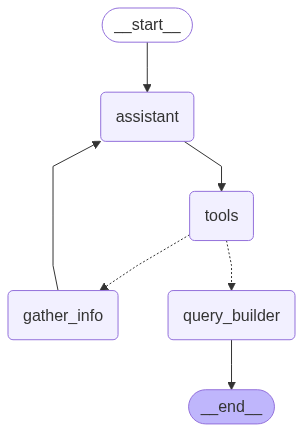

In [11]:
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [ ]:
messages = [HumanMessage(content="Explain the penalties for violating agricultural market ")]# regulations in new york
resp = react_graph.invoke({"messages": messages, "query":messages[0].content})
mm =resp['messages']
for m in mm:
    m.pretty_print()

In [17]:
import uuid
from typing import Optional
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph
from langgraph.types import interrupt


class State(TypedDict):
    """The graph state."""

    foo: str
    human_value: Optional[str]
    """Human value will be updated using an interrupt."""


def node(state: State):
    answer = interrupt(
        # This value will be sent to the client
        # as part of the interrupt information.
        "what is your age?"
    )
    print(f"> Received an input from the interrupt: {answer}")
    return {"human_value": answer}


builder = StateGraph(State)
builder.add_node("node", node)
builder.add_edge(START, "node")

# A checkpointer must be enabled for interrupts to work!
checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
    }
}
result = graph.invoke({'foo': "original text"}, config=config) 
print(result['__interrupt__']) 
print(result['__interrupt__']) 
# > [
# >    Interrupt(
# >       value={'text_to_revise': 'original text'}, 
# >       resumable=True,
# >       ns=['human_node:6ce9e64f-edef-fe5d-f7dc-511fa9526960']
# >    )
# > ] 

graph.invoke(Command(resume="answer"), config=config)

[Interrupt(value='what is your age?', resumable=True, ns=['node:55d94230-02e5-94f5-c283-eaf980dd48bf'])]
[Interrupt(value='what is your age?', resumable=True, ns=['node:55d94230-02e5-94f5-c283-eaf980dd48bf'])]
> Received an input from the interrupt: answer


{'foo': 'original text', 'human_value': 'answer'}

In [ ]:
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI
from research_tool_rag.configs import config
from research_tool_rag.rag.pipeline import RAGPipeline
from langgraph.graph import START, StateGraph, MessagesState
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_ollama.chat_models import ChatOllama
print()

class State1(MessagesState):
    a: int
    b: int
    c: str

class State2(MessagesState):
    c: str

# Initialize Config and Pipeline
config.use_config("online")
pipeline = RAGPipeline()
def add(tool_call_id: Annotated[str, InjectedToolCallId],a: int, b: int) -> Command:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return Command(update={"c":"state_abbrev", "messages":[ToolMessage(
                "Successfully updated state_code and law_type",
                tool_call_id=tool_call_id
            )]})

def multiply(a: int, b: int) -> int:
    """Multiplies a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

# Define LLM with bound tools
# llm = llm(model="gpt-4o")
llm_with_tools = pipeline.llm.bind_tools(tools)

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with writing performing arithmetic on a set of inputs.")

# Node
def assistant(state: State1)-> State2:
   breakpoint()
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Build graph
builder = StateGraph(State1)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

# Compile graph
graph = builder.compile()


In [48]:
from typing import TypedDict
import uuid

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver

# Define the graph state
class State(TypedDict):
    summary: str

# Simulate an LLM summary generation
def generate_summary(state: State) -> State:
    return {
        "summary": "The cat sat on the mat and looked at the stars."
    }

# Human editing node
def human_review_edit(state: State) -> State:
    result = interrupt({
        "task": input("enter task"),
        "generated_summary": state["summary"]
    })
    return {
        "summary": result["edited_summary"]
    }

# Simulate downstream use of the edited summary
def downstream_use(state: State) -> State:
    print(f"✅ Using edited summary: {state['summary']}")
    return state

# Build the graph
builder = StateGraph(State)
builder.add_node("generate_summary", generate_summary)
builder.add_node("human_review_edit", human_review_edit)
builder.add_node("downstream_use", downstream_use)

builder.set_entry_point("generate_summary")
builder.add_edge("generate_summary", "human_review_edit")
builder.add_edge("human_review_edit", "downstream_use")
builder.add_edge("downstream_use", END)

# Set up in-memory checkpointing for interrupt support
checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

# Invoke the graph until it hits the interrupt
config = {"configurable": {"thread_id": uuid.uuid4()}}
result = graph.invoke({}, config=config)

# Output interrupt payload
print(result["__interrupt__"])
# Example output:
# Interrupt(
#   value={
#     'task': 'Please review and edit the generated summary if necessary.',
#     'generated_summary': 'The cat sat on the mat and looked at the stars.'
#   },
#   resumable=True,
#   ...
# )

# Resume the graph with human-edited input
edited_summary = "The cat lay on the rug, gazing peacefully at the night sky."
resumed_result = graph.invoke(
    Command(resume={"edited_summary": edited_summary}),
    config=config
)
print(resumed_result)

[Interrupt(value={'task': 'joke', 'generated_summary': 'The cat sat on the mat and looked at the stars.'}, resumable=True, ns=['human_review_edit:9b40d434-dc77-4d98-bc6c-8c407fc42993'])]
✅ Using edited summary: The cat lay on the rug, gazing peacefully at the night sky.
{'summary': 'The cat lay on the rug, gazing peacefully at the night sky.'}


In [49]:
from pydantic.config import ConfigDict
from pydantic import Field
class Model(BaseModel):
          __pydantic_extra__: dict[str, int] = Field(init=False)  # (1)!

          x: int

          model_config = ConfigDict(extra='allow')


try:
    Model(x=1, y='a')
except Exception as exc:
    print(exc)
    """
    1 validation error for Model
    y
    Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='a', input_type=str]
    """

m = Model(x=1, y='2')
assert m.x == 1
assert m.y == 2
assert m.model_dump() == {'x': 1, 'y': 2}
assert m.__pydantic_extra__ == {'y': 2}

1 validation error for Model
y
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='a', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/int_parsing


In [50]:
m.__pydantic_extra__

{'y': 2}

In [51]:
from langgraph.graph import StateGraph
from typing import TypedDict
from pydantic import Extra, BaseModel
from pydantic.config import ConfigDict
# Define state schema
class MyState(BaseModel):
    count: int

# Class-based node
class Incrementer:
    def __init__(self, increment: int):
        self.increment = increment

    def __call__(self, state: MyState) -> MyState:
        state.count = self.increment
        return state

# Create graph
graph = StateGraph(MyState)
graph.add_node("increment", Incrementer(5))
graph.set_entry_point("increment")

# Compile and run
app = graph.compile()

result = app.invoke({"count": 10})
print(result)  # Output: {'count': 15}


{'count': 5}


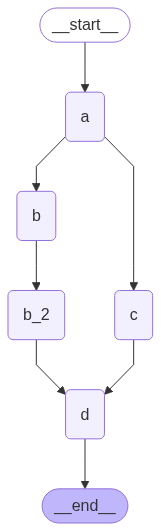

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "B_2" to ['A', 'B', 'C']
Adding "D" to ['A', 'B', 'C', 'B_2']


{'aggregate': ['A', 'B', 'C', 'B_2', 'D']}

In [2]:
import operator
from typing import Annotated, Any

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]


def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def b_2(state: State):
    print(f'Adding "B_2" to {state["aggregate"]}')
    return {"aggregate": ["B_2"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}


builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(b_2)
builder.add_node(c)
builder.add_node(d, defer=True)
builder.add_edge(START, "a")
builder.add_edge("a", "c")
builder.add_edge("a", "b")
builder.add_edge("b", "b_2")
builder.add_edge("b_2", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"aggregate": []})



2025-06-29 10:37:26,590 - httpx - INFO - HTTP Request: GET http://localhost:6333 "HTTP/1.1 200 OK"
2025-06-29 10:37:26,590 - httpx - INFO - HTTP Request: GET http://localhost:6333 "HTTP/1.1 200 OK"
2025-06-29 10:37:26,590 - httpx - INFO - HTTP Request: GET http://localhost:6333 "HTTP/1.1 200 OK"
2025-06-29 10:37:26,590 - httpx - INFO - HTTP Request: GET http://localhost:6333 "HTTP/1.1 200 OK"


2025-06-29 10:37:26,590 - httpx - INFO - HTTP Request: GET http://localhost:6333 "HTTP/1.1 200 OK"
2025-06-29 10:37:26,590 - httpx - INFO - HTTP Request: GET http://localhost:6333 "HTTP/1.1 200 OK"
2025-06-29 10:37:26,590 - httpx - INFO - HTTP Request: GET http://localhost:6333 "HTTP/1.1 200 OK"
2025-06-29 10:37:26,599 - httpx - INFO - HTTP Request: GET http://localhost:6333/collections/US_LAWS/exists "HTTP/1.1 200 OK"
2025-06-29 10:37:26,599 - httpx - INFO - HTTP Request: GET http://localhost:6333/collections/US_LAWS/exists "HTTP/1.1 200 OK"
2025-06-29 10:37:26,599 - httpx - INFO - HTTP Request: GET http://localhost:6333/collections/US_LAWS/exists "HTTP/1.1 200 OK"
2025-06-29 10:37:26,599 - httpx - INFO - HTTP Request: GET http://localhost:6333/collections/US_LAWS/exists "HTTP/1.1 200 OK"
2025-06-29 10:37:26,599 - httpx - INFO - HTTP Request: GET http://localhost:6333/collections/US_LAWS/exists "HTTP/1.1 200 OK"
2025-06-29 10:37:26,599 - httpx - INFO - HTTP Request: GET http://localho

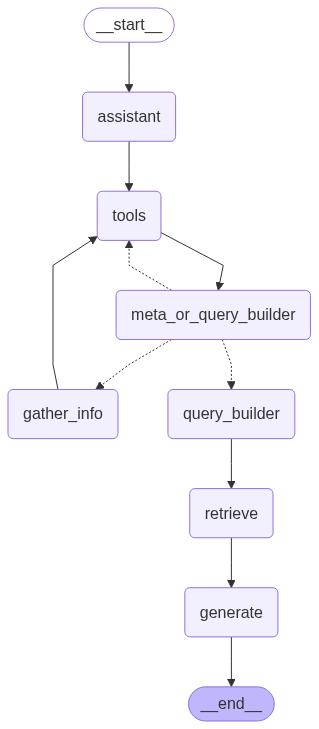

In [ ]:
import logging
from typing import Literal, Optional, Annotated, List

from langchain.tools import Tool
from langchain_core.tools import tool, InjectedToolCallId
from langchain_core.messages import trim_messages, HumanMessage, SystemMessage, ToolMessage, ChatMessage
from langgraph.types import Command, interrupt
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, PromptTemplate

from research_tool_rag.configs import config
from research_tool_rag.rag.pipeline import RAGPipeline
from research_tool_rag.utils.utils import setup_logging

# Setup logging
logger = logging.getLogger(__name__)
setup_logging("ingest_data", stream_handler=True)

# Initialize config and pipeline
config.use_config("online")
pipeline = RAGPipeline()

# Literal types for US states and law type
USStateAbbrev = Literal[
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "ID", "IL", "IN",
    "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV",
    "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN",
    "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]
LawType = Literal["laws", "regulations"]

# Define the graph state
class ExtractState(MessagesState):
    query: str
    state_code: Optional[str]
    law_type: Optional[str]
    expanded_query: Optional[str]
    correction: str
    tool_attempts: int = 0
    context: str
    answer: str
    sources: List['str']
    tool_attempts: int = 0

# Tool to update state with US state and law type
@tool
def get_us_state_lawtype(
    tool_call_id: Annotated[str, InjectedToolCallId],
    state_abbrev: USStateAbbrev,
    law_type: LawType = ""
) -> Command:
    """Update state with US state abbreviation and optional law type."""
    return Command(update={
        "state_code": state_abbrev,
        "law_type": law_type,
        "messages": [ToolMessage("Updated state_code and law_type", tool_call_id=tool_call_id)]
    })

# Bind tools to LLM
llm_with_tools = pipeline.llm.bind_tools([get_us_state_lawtype])

# Assistant node to extract state and law type
def assistant(state: ExtractState):
    messages = trim_messages(
        state["messages"], max_tokens=100000, strategy="last", token_counter=pipeline.llm, allow_partial=False
    )
    response = llm_with_tools.invoke(
        [SystemMessage(content="Extract state code and law type from the following messages.")] + messages[-1:]
    )
    return {"messages": [response], 'query':messages[0].content}

# Query builder node to expand query
def query_builder(state: ExtractState):
    prompt_template = ChatPromptTemplate(
        input_variables=["query"],
        messages=[
            HumanMessagePromptTemplate(
                prompt=PromptTemplate(
                    input_variables=["query"],
                    template="Expand or refine the following legal query for clarity and precision:\nQuery: {query}\nExpanded query:"
                )
            )
        ]
    )
    breakpoint()
    message = prompt_template.invoke({"query": state["query"]})
    response = llm_with_tools.invoke(message)
    return {"messages": [response], "expanded_query": response.content}

# Conditional edge selector
def meta_or_query_builder(state: ExtractState) -> Command[Literal['query_builder','gather_info','tools']]:
    breakpoint()
    if state.get("state_code"):
        goto="query_builder"
        tool_attmpt = 0
    elif state.get("tool_attempts", 0) >= 5:
        tool_attmpt = 0
        goto='gather_info'
    else:
        tool_attmpt = state.get("tool_attempts", 0)+1
        goto="tools"

    return Command(update={
            "tool_attempts": tool_attmpt,
            # "messages": [ChatMessage(content="Updated tool_attempt number and going to gather info",role='bot')]
            },
            goto=goto)

# Gather info node (interrupt-based)
def gather_info(state: ExtractState):
    value =  interrupt(input"what is the state and laws you are interested in"))
    return {"messages": [HumanMessage(content=value)]}

# # Wrapper node for tool with retry counter
# def tool_with_retry(tool_call_id: Annotated[str, InjectedToolCallId], state: ExtractState):
#     breakpoint()
#     state["tool_attempts"] = state.get("tool_attempts", 0) + 1
#     Command(update={
#         "tool_attempts": state.get("tool_attempts", 0) + 1,
#         "messages": [ToolMessage("Updated tool_attempt number", tool_call_id=tool_call_id)]
#     }
#     goto=)
#     return ToolNode([get_us_state_lawtype]).invoke(state)

# Retrieval node using RAGPipeline
def retrieve(state: ExtractState):
    retrieved = pipeline.retrieve({"question": state["expanded_query"] or state["query"]})
    return {"context": retrieved["context"]}

# Generation node using RAGPipeline
def generate(state: ExtractState):
    overall_state = {
        "question": state["expanded_query"] or state["query"],
        "context": state["context"]
    }
    generated = pipeline.generate(overall_state)
    return {"answer": generated["answer"], "sources": generated["sources"]}

# Build LangGraph
builder = StateGraph(ExtractState)
builder.add_node("assistant", assistant)
builder.add_node("gather_info", gather_info)
builder.add_node("query_builder", query_builder)
builder.add_node("meta_or_query_builder",meta_or_query_builder)
builder.add_node("tools", ToolNode([get_us_state_lawtype]))
builder.add_node("retrieve", retrieve)
builder.add_node("generate", generate)

builder.add_edge(START, "assistant")
builder.add_edge("assistant", "tools")
builder.add_edge("tools", "meta_or_query_builder")
builder.add_edge("gather_info", "tools")
builder.add_edge("query_builder", "retrieve")
builder.add_edge("retrieve", "generate")
builder.add_edge("generate", END)

rag_graph = builder.compile()
display(Image(rag_graph.get_graph().draw_mermaid_png()))
# if __name__ == "__main__":
#     messages = [
#         HumanMessage(content="Explain the penalties for violating agricultural market")# regulations in New York.
#     ]
#     config_obj = {"configurable": {"thread_id": "test-thread"}}  # Optional but good for interrupt tracking

#     # Initial run
#     result = rag_graph.invoke({"messages": messages}, config=config_obj)

#     while "__interrupt__" in result:
#         interrupt_payload = result["__interrupt__"]
#         print(f"\n🚨 Interrupt triggered: {interrupt_payload}")

#         # Simulate user providing the missing information via CLI
#         user_state = input(f"\n{interrupt_payload['instruction']}\nProvide your input: ")

#         # Resume the graph with user's input
#         result = rag_graph.invoke(
#             Command(resume={"messages": [HumanMessage(content=user_state)]}),
#             config=config_obj
#         )

#     # Final result
#     for m in result.get("messages", []):
#         m.pretty_print()
#     print("\nFinal Answer:", result.get("answer"))
#     print("Sources:", result.get("sources"))


In [ ]:
from langchain_mcp_adapters.tools import load_mcp_tools

In [ ]:
import mcp